In [39]:
import pandas as pd
import lightgbm as lgb
import h2o
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from numpy import percentile


In [53]:
dataset = pd.read_csv('Yes_Bank_Training.csv')
test = pd.read_csv('Yes_Bank_Test.csv')
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
dataset_cat= dataset["outcome"]
dataset_encoded= encoder.fit_transform(dataset_cat)
dataset_encoded
dataset['outcome']=dataset_encoded

test_final=test
dataset.head()

serial_number  age_in_years job_description marital_status  \
0              1            58      management        married   
1              2            44      technician         single   
2              3            33    entrepreneur        married   
3              4            47     blue-collar        married   
4              5            33         unknown         single   

  education_details has_default  balance_in_account housing_status  \
0          tertiary          no                2143            yes   
1         secondary          no                  29            yes   
2         secondary          no                   2            yes   
3           unknown          no                1506            yes   
4           unknown          no                   1             no   

  previous_loan phone_type  date month_of_year  call_duration  \
0            no    unknown     5           may            261   
1            no    unknown     5           may            151   
2           yes    unknown     5           may             76   
3            no    unknown     5           may             92   
4            no    unknown     5           may            198   

   campaign_contacts  days_passed  previous_contact poutcome_of_campaign  \
0                  1           -1                 0              unknown   
1                  1           -1                 0              unknown   
2                  1           -1                 0              unknown   
3                  1           -1                 0              unknown   
4                  1           -1                 0              unknown   

   outcome  
0        0  
1        0  
2        0  
3        0  
4        0

### We have a highly skewed dataset, therefore we decided to go with RoC_AUC as our evaluation metric
### Strategies to try upsample, Smote

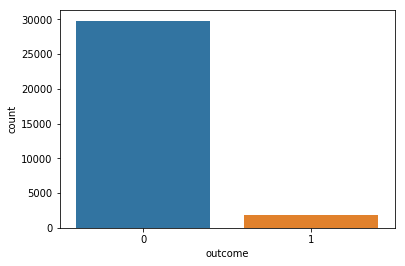

In [54]:
sns.countplot(x=dataset['outcome'], data=dataset)
plt.show()

### We can see that balance, age, call_duration, previous_contact have outliers, we will try to visualize these 

In [55]:
dataset.describe()

serial_number  age_in_years  balance_in_account          date  \
count   31649.000000  31649.000000        31649.000000  31649.000000   
mean    15825.000000     41.111820         1293.382540     16.597997   
std      9136.423671      9.597652         2961.185138      8.586414   
min         1.000000     19.000000        -8019.000000      1.000000   
25%      7913.000000     33.000000           47.000000      9.000000   
50%     15825.000000     40.000000          397.000000     18.000000   
75%     23737.000000     49.000000         1328.000000     23.000000   
max     31649.000000     94.000000        98417.000000     31.000000   

       call_duration  campaign_contacts   days_passed  previous_contact  \
count   31649.000000       31649.000000  31649.000000      31649.000000   
mean      252.408196           3.062372     10.819931          0.208537   
std       262.344981           3.510245     48.086849          1.946336   
min         0.000000           1.000000     -1.000000          0.000000   
25%        98.000000           1.000000     -1.000000          0.000000   
50%       171.000000           2.000000     -1.000000          0.000000   
75%       305.000000           3.000000     -1.000000          0.000000   
max      4918.000000          63.000000    335.000000        275.000000   

            outcome  
count  31649.000000  
mean       0.058138  
std        0.234007  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

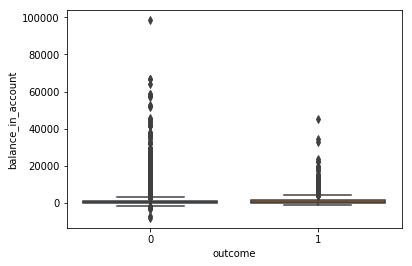

In [56]:
sns.boxplot(x=dataset['outcome'],y= dataset['balance_in_account']);


(0, 5000)

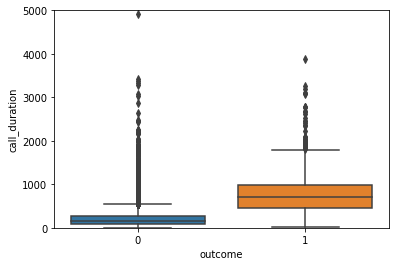

In [57]:
#DURATION
dataset['call_duration'].max()
sns.boxplot(x='outcome', y='call_duration', data=dataset)
plt.ylim(0, 5000)

(0, 100)

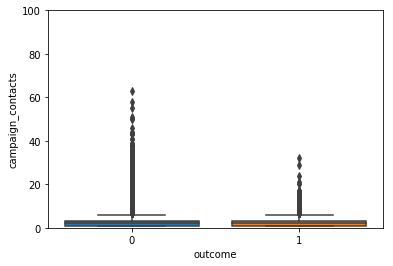

In [58]:
#campaign
dataset['campaign_contacts'].max()
sns.boxplot(x='outcome', y='campaign_contacts', data=dataset)
plt.ylim(0, 100)

(0, 350)

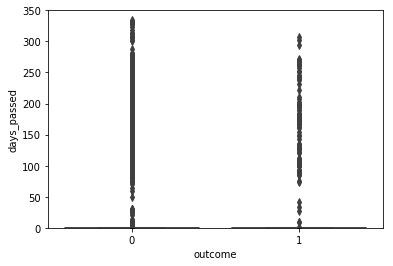

In [59]:
#days_passed
dataset['days_passed'].max()
sns.boxplot(x='outcome', y='days_passed', data=dataset)
plt.ylim(0, 350)

(0, 300)

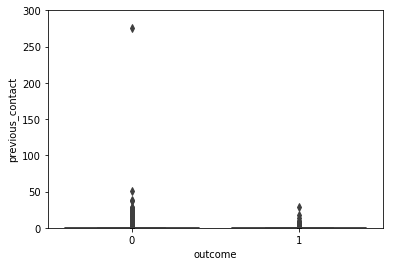

In [47]:
#previous_contact
dataset['previous_contact'].max()
sns.boxplot(x='outcome', y='previous_contact', data=dataset)
plt.ylim(0, 300)


### We treat these outliers using by scaling them using scikit learns StandardScaler() we observe similiar pattern in test set too

### In our eda we found that there were no missing values but a lot of varibales were labelled unkown, we used different strategies to deal with them(dropping, keeping them) we found replacing them with mode value gave optimal results

In [60]:
dataset_new=dataset
def impute_unknowns(df, column):
    col_values = df[column].values
    df[column] = np.where(col_values=='unknown', df[column].mode(), col_values)
    return df


job_description
admin.           10.597491
blue-collar      21.953300
entrepreneur      3.665203
housemaid         3.061708
management       21.185503
retired           3.892698
self-employed     3.677841
services          9.368384
student           0.938418
technician       17.959493
unemployed        3.001675
unknown           0.698284
dtype: float64


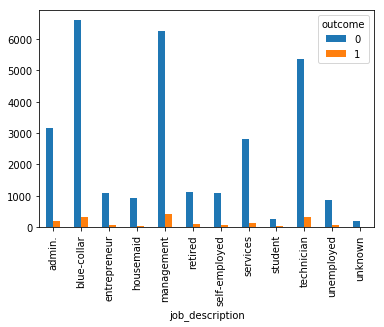

In [61]:
temp1 = pd.crosstab(dataset['job_description'], dataset['outcome'])
temp1.plot(kind='bar')
print(dataset.groupby(['job_description']).size()/len(dataset)*100)

education_details
primary      15.725615
secondary    51.511896
tertiary     28.743404
unknown       4.019084
dtype: float64


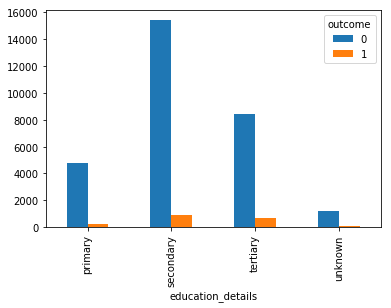

In [50]:
temp3 = pd.crosstab(dataset['education_details'], dataset['outcome'])
temp3.plot(kind='bar')
print(dataset.groupby(['education_details']).size()/len(dataset)*100)

In [62]:
dataset_new = impute_unknowns(df=dataset_new, column='education_details')
test_final = impute_unknowns(df=test_final, column='education_details')


job_description
admin.           10.597491
blue-collar      21.953300
entrepreneur      3.665203
housemaid         3.061708
management       21.185503
retired           3.892698
self-employed     3.677841
services          9.368384
student           0.938418
technician       17.959493
unemployed        3.001675
unknown           0.698284
dtype: float64


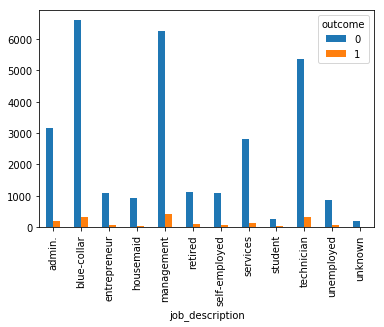

In [33]:
temp1 = pd.crosstab(dataset['job_description'], dataset['outcome'])
temp1.plot(kind='bar')
print(dataset.groupby(['job_description']).size()/len(dataset)*100)


In [63]:
dataset_new = impute_unknowns(df=dataset_new, column='education_details')
test_final = impute_unknowns(df=test_final, column='job_description')


#### We found lot of unknown variables in phone type and poutcome of campaign, so we drop these variables

phone_type
cellular     54.286075
telephone     5.380897
unknown      40.333028
dtype: float64


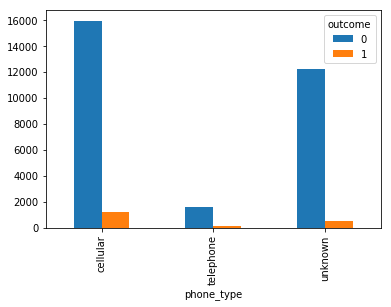

In [36]:
temp6 = pd.crosstab(dataset['phone_type'], dataset['outcome'])
temp6.plot(kind='bar')
print(dataset.groupby(['phone_type']).size()/len(dataset)*100)

poutcome_of_campaign
failure     4.546747
other       1.699896
success     0.255932
unknown    93.497425
dtype: float64


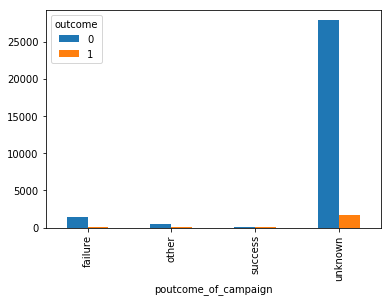

In [38]:
temp8 = pd.crosstab(dataset['poutcome_of_campaign'], dataset['outcome'])
temp8.plot(kind='bar')
print(dataset.groupby(['poutcome_of_campaign']).size()/len(dataset)*100)

In [ ]:
temp3 = pd.crosstab(dataset['education_details'], dataset['outcome'])
temp3.plot(kind='bar')
print(dataset.groupby(['education_details']).size()/len(dataset)*100)

### We used the following feature engineering methods which gave us promising results
### Convert seconds in call_duration to minutes and make it categorical and group people in age groups namely middle aged, adult, old
### We considered grouping job categories into blue, white, pink collar but decided to drop them

In [64]:
def age_(data):
    
    data['Adult'] = 0
    data['Middle_Aged'] = 0
    data['old'] = 0    
    data.loc[(data['age_in_years'] <= 35) & (data['age_in_years'] >= 18),'Adult'] = 1
    data.loc[(data['age_in_years'] <= 60) & (data['age_in_years'] >= 36),'Middle_Aged'] = 1
    #data.loc[(data['age'] <= 60) & (data['age'] >= 46),'Elderly'] = 1
    data.loc[data['age_in_years'] >=61,'old'] = 1
    
    return data


def duration_(data):
    
    data['t_min'] = 0
    data['t_e_min'] = 0
    data['e_min']=0
    data.loc[data['call_duration'] <= 5,'t_min'] = 1
    data.loc[(data['call_duration'] > 5) & (data['call_duration'] <= 10),'t_e_min'] = 1
    data.loc[data['call_duration'] > 10,'e_min'] = 1
    
    return data

def pdays_(data):
    data['pdays_not_contacted'] = 0
    data['months_passed'] = 0
    data.loc[data['days_passed'] == -1 ,'pdays_not_contacted'] = 1
    data['months_passed'] = data['days_passed']/30
    data.loc[(data['months_passed'] >= 0) & (data['months_passed'] <=2) ,'months_passed'] = 1
    data.loc[(data['months_passed'] > 2) & (data['months_passed'] <=6),'months_passed'] = 2
    data.loc[data['months_passed'] > 6 ,'months_passed'] = 3
    
    return data



In [65]:
dataset_1 = age_(dataset_new)
dataset_1 = duration_(dataset_new)
dataset_1 = pdays_(dataset_new)


test_1 = age_(test_final)
test_1 = duration_(test_final)
test_1 = pdays_(test_final)

dataset_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31649 entries, 0 to 31648
Data columns (total 26 columns):
serial_number           31649 non-null int64
age_in_years            31649 non-null int64
job_description         31649 non-null object
marital_status          31649 non-null object
education_details       31649 non-null object
has_default             31649 non-null object
balance_in_account      31649 non-null int64
housing_status          31649 non-null object
previous_loan           31649 non-null object
phone_type              31649 non-null object
date                    31649 non-null int64
month_of_year           31649 non-null object
call_duration           31649 non-null int64
campaign_contacts       31649 non-null int64
days_passed             31649 non-null int64
previous_contact        31649 non-null int64
poutcome_of_campaign    31649 non-null object
outcome                 31649 non-null int32
Adult                   31649 non-null int64
Middle_Aged             316

**Scaling**

To scale: Age, Balance, Call Duration, days passed.

In [66]:
from sklearn.preprocessing import StandardScaler as ss
scaled_train = pd.DataFrame(dataset_1).copy()

col_names = ['age_in_years', 'balance_in_account', 'call_duration', 'days_passed']
features = scaled_train[col_names]
scaler = ss().fit(features.values)
features = scaler.transform(features.values)

scaled_train[col_names] = features
#strangely, age_in_years had a duplicate column at the end, so we drop it here
#scaled_train=scaled_train.drop(scaled_train.columns[18],axis=1)
scaled_train.head() 


C:\Users\Niranjan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Niranjan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


serial_number  age_in_years job_description marital_status  \
0              1      1.759644      management        married   
1              2      0.300930      technician         single   
2              3     -0.845201    entrepreneur        married   
3              4      0.613512     blue-collar        married   
4              5     -0.845201         unknown         single   

  education_details has_default  balance_in_account housing_status  \
0          tertiary          no            0.286923            yes   
1         secondary          no           -0.426992            yes   
2         secondary          no           -0.436110            yes   
3         secondary          no            0.071803            yes   
4         secondary          no           -0.436448             no   

  previous_loan phone_type      ...        poutcome_of_campaign outcome  \
0            no    unknown      ...                     unknown       0   
1            no    unknown      ...                     unknown       0   
2           yes    unknown      ...                     unknown       0   
3            no    unknown      ...                     unknown       0   
4            no    unknown      ...                     unknown       0   

   Adult  Middle_Aged  old  t_min t_e_min  e_min  pdays_not_contacted  \
0      0            1    0      0       0      1                    1   
1      0            1    0      0       0      1                    1   
2      1            0    0      0       0      1                    1   
3      0            1    0      0       0      1                    1   
4      1            0    0      0       0      1                    1   

   months_passed  
0      -0.033333  
1      -0.033333  
2      -0.033333  
3      -0.033333  
4      -0.033333  

[5 rows x 26 columns]

In [67]:
scaled_test = pd.DataFrame(test_1).copy()

col_names = ['age_in_years', 'balance_in_account', 'call_duration', 'days_passed']
features = scaled_test[col_names]
scaler = ss().fit(features.values)
features = scaler.transform(features.values)

scaled_test[col_names] = features

scaled_test.head() 

C:\Users\Niranjan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Niranjan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


serial_number  age_in_years job_description marital_status  \
0              1     -0.593734          admin.        married   
1              2     -0.041526      management        married   
2              3     -0.830394      technician         single   
3              4      0.274022     blue-collar        married   
4              5     -0.435960      technician        married   

  education_details has_default  balance_in_account housing_status  \
0         secondary          no           -0.225389            yes   
1         secondary          no           -0.238410             no   
2         secondary          no            2.675073            yes   
3         secondary          no           -0.303202            yes   
4         secondary          no            1.249333            yes   

  previous_loan phone_type      ...        previous_contact  \
0            no  telephone      ...                       0   
1           yes   cellular      ...                       0   
2            no   cellular      ...                       1   
3            no   cellular      ...                       1   
4            no   cellular      ...                       7   

  poutcome_of_campaign  Adult  Middle_Aged  old  t_min t_e_min  e_min  \
0              unknown      1            0    0      0       0      1   
1              unknown      0            1    0      0       0      1   
2              failure      1            0    0      0       0      1   
3              failure      0            1    0      0       0      1   
4              failure      1            0    0      0       0      1   

   pdays_not_contacted  months_passed  
0                    1      -0.033333  
1                    1      -0.033333  
2                    0       3.000000  
3                    0       2.000000  
4                    0       2.000000  

[5 rows x 25 columns]

In [68]:
y= dataset_1['outcome']
X = dataset_1.drop([ 'serial_number','phone_type','poutcome_of_campaign','date'], axis=1)
X_test = test_1.drop(['serial_number','phone_type','poutcome_of_campaign','date'], axis=1)



### Label Encode binary variables and one hot encode other categorical variables

In [69]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in X:
    if X[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(X[col].unique())) <= 2:
            # Train on the training data
            le.fit(X[col])
            # Transform both training and testing data
            X[col] = le.transform(X[col])
            X_test[col] = le.transform(X_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)
train_labels = X['outcome']
# Align the training and testing data, keep only columns present in both dataframes
X, X_test = X.align(X_test, join = 'inner', axis = 1)
# Add the target back in
X['outcome'] = train_labels
print('Training Features shape: ', X.shape)
print('Testing Features shape: ', X_test.shape)


3 columns were label encoded.
Training Features shape:  (31649, 46)
Testing Features shape:  (13562, 45)


In [70]:
h2o.init()
from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -------------------------------
H2O cluster uptime:         1 hour 44 mins
H2O cluster timezone:       Asia/Kolkata
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.2
H2O cluster version age:    18 days
H2O cluster name:           H2O_from_python_Niranjan_hrge6g
H2O cluster total nodes:    1
H2O cluster free memory:    1.568 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Algos, AutoML, Core V3, Core V4
Python version:             3.6.6 final
--------------------------  -------------------------------

### After a long struggle with base line models we decided to try out auto ml which gave significant improvement in the leaderboard

In [72]:
hT = h2o.H2OFrame(X)
x = hT.columns
y ='outcome'
x.remove(y)
hT['outcome'] = hT['outcome'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [73]:
aml = H2OAutoML(nfolds=10, max_runtime_secs = 60*3, stopping_metric='logloss', sort_metric='logloss', seed=79)
aml.train(x = x, y = y, training_frame=hT)

AutoML progress: |█████████████████████████████████████████████████████████| 100%


# Preparing Submissions

In [ ]:
preds = aml.leader.predict(h2o.H2OFrame(frame_test))
preds = preds.as_data_frame()